In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

En primer lugar leemos los datos del experimento. Para ello los almacenamos en forma de dataframes. Creamos tres dataframes que hacen referencia a los datos de contro (trozoC), a los de la inyección del Gaba (trozoG) y a los de recuperación (trozoR)

In [3]:
trozoC = pd.read_csv("TrozoC.txt", names=["LP", "VD"], delimiter="\t", decimal=",", skiprows=range(3), index_col=False)
#trozoC

In [4]:
trozoG = pd.read_csv("TrozoG.txt", names=["LP", "VD", "T"], delimiter="\t", decimal=",", skiprows=range(3), index_col=False)
#trozoG

In [5]:
trozoR = pd.read_csv("TrozoR.txt", names=["LP", "VD"], delimiter="\t", decimal=",", skiprows=range(3), index_col=False)
#trozoR

Representamos los datos que acabamos de leer

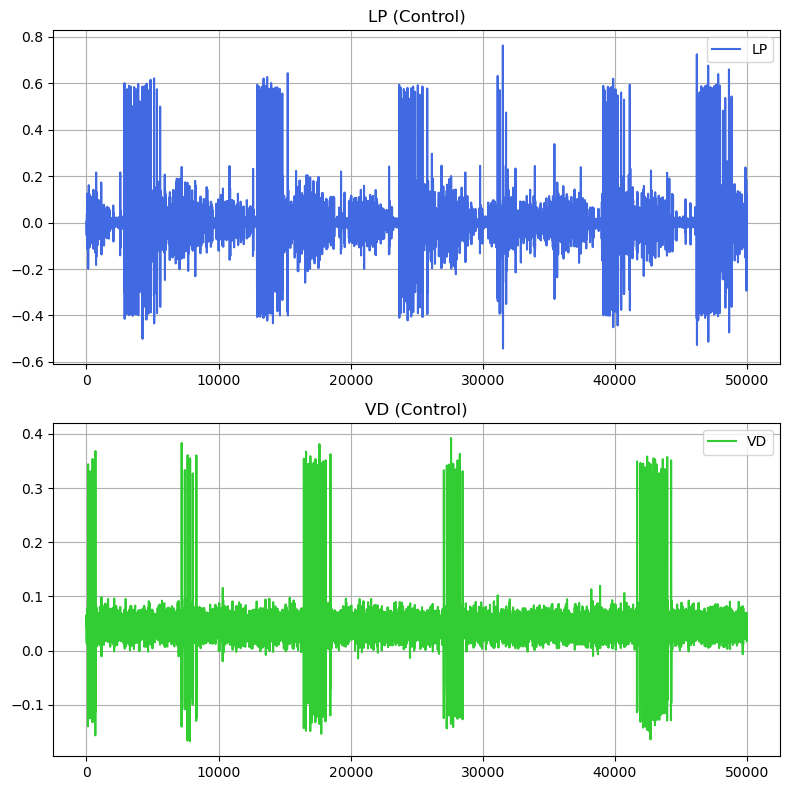

In [6]:
timelim = 50000
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(trozoC['LP'].head(timelim), label='LP', color='royalblue')
axs[0].set_title('LP (Control)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(trozoC['VD'].head(timelim), label='VD', color='limegreen')
axs[1].set_title('VD (Control)')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

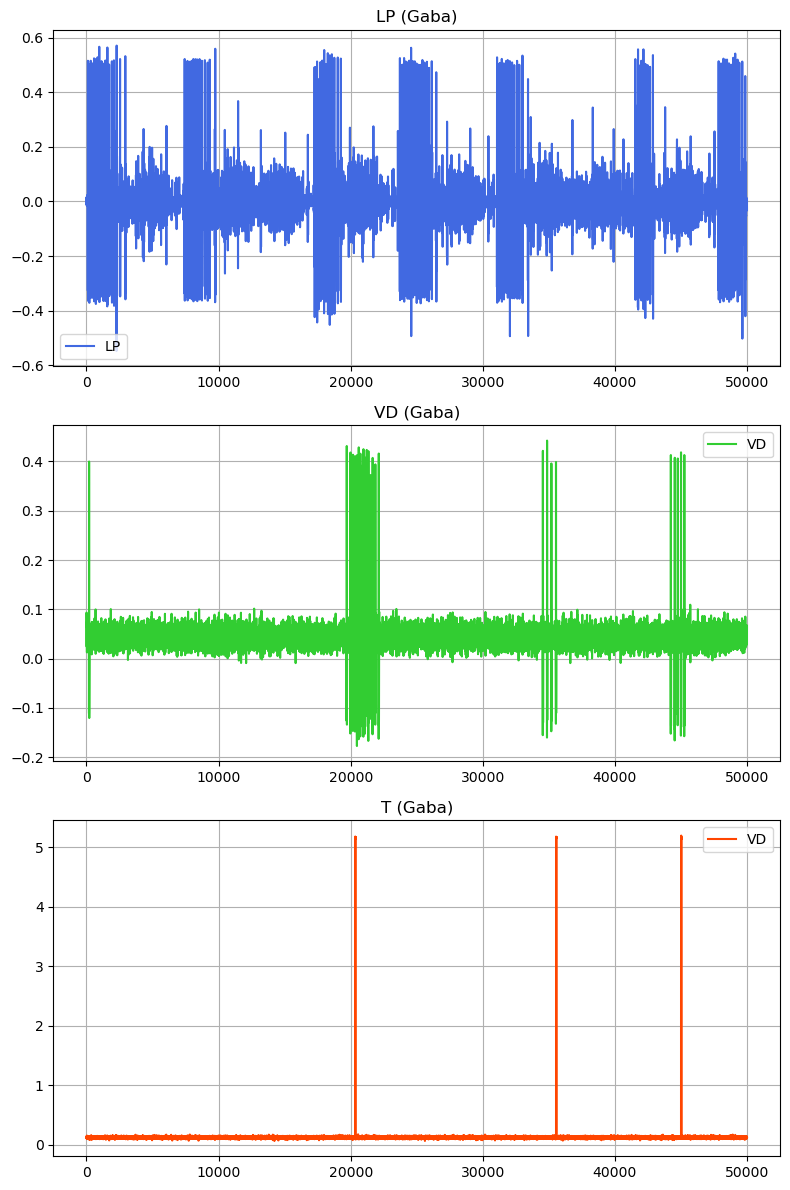

In [163]:
timelim = 50000
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].plot(trozoG['LP'].head(timelim), label='LP', color='royalblue')
axs[0].set_title('LP (Gaba)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(trozoG['VD'].head(timelim), label='VD', color='limegreen')
axs[1].set_title('VD (Gaba)')
axs[1].legend()
axs[1].grid(True)


axs[2].plot(trozoG['T'].head(timelim), label='VD', color='orangered')
axs[2].set_title('T (Gaba)')
axs[2].legend()
axs[2].grid(True)


plt.tight_layout()
plt.show()

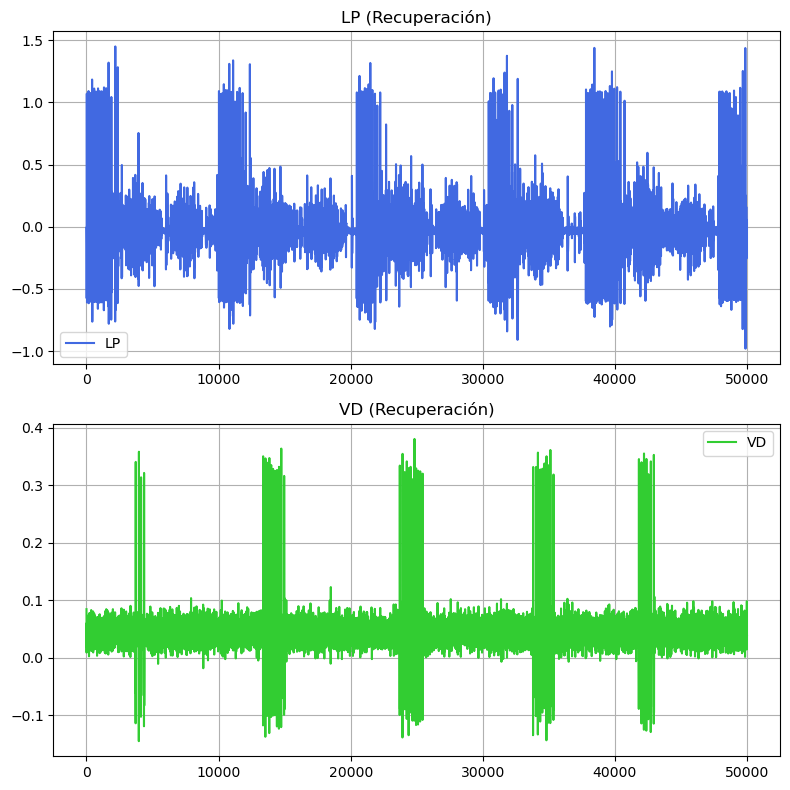

In [7]:
timelim = 50000
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(trozoR['LP'].head(timelim), label='LP', color='royalblue')
axs[0].set_title('LP (Recuperación)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(trozoR['VD'].head(timelim), label='VD', color='limegreen')
axs[1].set_title('VD (Recuperación)')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

Nuestro objetivo es el de, a partir de estos datos recogidos en el laboratorio, pasarlos a formato de ceros y unos. Haremos corresponder un 1 a la presencia de un spike en la señal o un 0 en ausencia de este. Para ello escogemos un umbral a partir de cual una señal de mayor magnitud que nuestro umbral será considerada como un spike. 

In [8]:
#Control
umbralLPC = 0.4
SLPC = (trozoC['LP'] > umbralLPC).astype(int)
umbralVDC = 0.25
SVDC = (trozoC['VD'] > umbralVDC).astype(int)
#Gaba
umbralLPG = 0.4
SLPG = (trozoG['LP'] > umbralLPG).astype(int)
umbralVDG = 0.25
SVDG = (trozoG['VD'] > umbralVDG).astype(int)
umbralTG = 3.0
STG = (trozoG['T'] > umbralTG).astype(int)
#Recuperación
umbralLPR = 0.75
SLPR = (trozoR['LP'] > umbralLPR).astype(int)
umbralVDR = 0.25
SVDR = (trozoR['VD'] > umbralVDR).astype(int)

Representamos la transformación en ceros y unos dato a dato

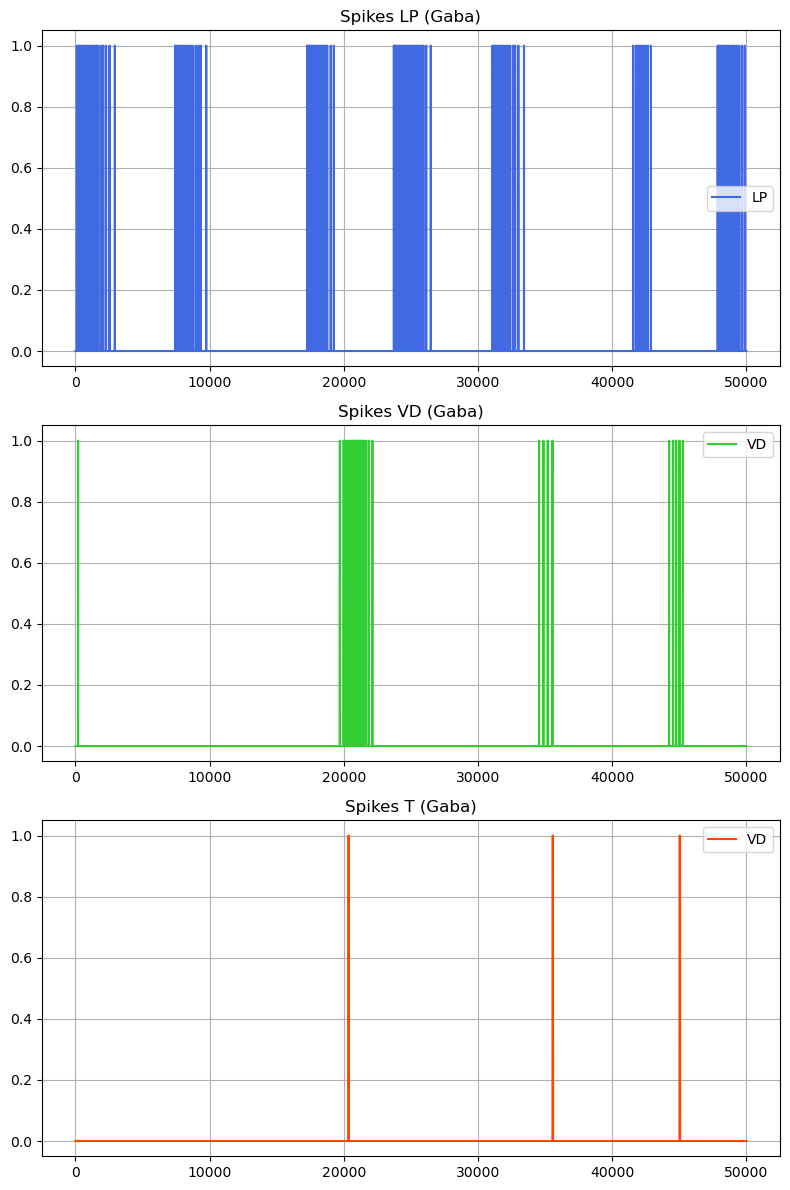

In [9]:
timelim = 50000
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].plot(SLPG.head(timelim), label='LP', color='royalblue')
axs[0].set_title('Spikes LP (Gaba)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(SVDG.head(timelim), label='VD', color='limegreen')
axs[1].set_title('Spikes VD (Gaba)')
axs[1].legend()
axs[1].grid(True)


axs[2].plot(STG.head(timelim), label='VD', color='orangered')
axs[2].set_title('Spikes T (Gaba)')
axs[2].legend()
axs[2].grid(True)


plt.tight_layout()
plt.show()

Sin embargo, no queremos transformar directamente nuestra señal en ceros y unos mirando a cada uno de los datos recogidos. Queremos establecer una ventana de tiempo que utilizaremos para contabilizar el número de spikes. Si en esa ventana de tiempo existe algún dato por encima de cierto umbral consideraremos un spike.

In [10]:
# Creamos una función que calcule loos spikes en función del tamaño de ventana
# trozo = 'trozoC', 'trozoG', 'trozoR'
# columna = 'LP', 'VD', 'T'
# venana = intervalo de tiempo dado en ms

def señalporventana(trozo,columna,ventana):

     #Definimos el umbral y los datos
    if trozo == 'trozoC':
        if columna == 'LP':
            umbral = umbralLPC
            data = trozoC['LP']
        if columna == 'VD':
            umbral = umbralVDC
            data = trozoC['VD']
    if trozo == 'trozoG':
        if columna == 'LP':
            umbral = umbralLPG
            data = trozoG['LP']
        if columna == 'VD':
            umbral = umbralVDG
            data = trozoG['VD']
        if columna == 'T':
            umbral = umbralTG
            data = trozoG['T']
    if trozo == 'trozoR':
        if columna == 'LP':
            umbral = umbralLPR
            data = trozoR['LP']
        if columna == 'VD':
            umbral = umbralVDR
            data = trozoR['VD']

    # Crear un vector de tiempo
    tiempo = np.arange(0,len(data),ventana, dtype=int)

    # Crear una salida para el tiempo y la señal inicializado con ceros
    output = np.zeros((len(tiempo),2))
    output[:,0] = tiempo
    
   
    # Iterar sobre el DataFrame
    for i in tiempo:
        # Obtener el rango de índices para el intervalo de tiempo actual
        rango_indices = range(i, i + int(ventana))
        # Verificar si algún valor en el intervalo es mayor que 1.5
        if any(data.iloc[rango_indices] > umbral):
            output[int(i/int(ventana)),1] = 1
    return output

In [11]:
# Con este intervalo se tarda un par de minutos en generar la señal
señalLPC10 = señalporventana('trozoC','LP',10)

In [12]:
# Este intervalo es mucho más rápido
señalLPC100 = señalporventana('trozoC','LP',100)

In [13]:
señalVDC100 = señalporventana('trozoC','VD',100)

Representamos la booleana obtenida para el trozo de Control con una ventana de 100 ms

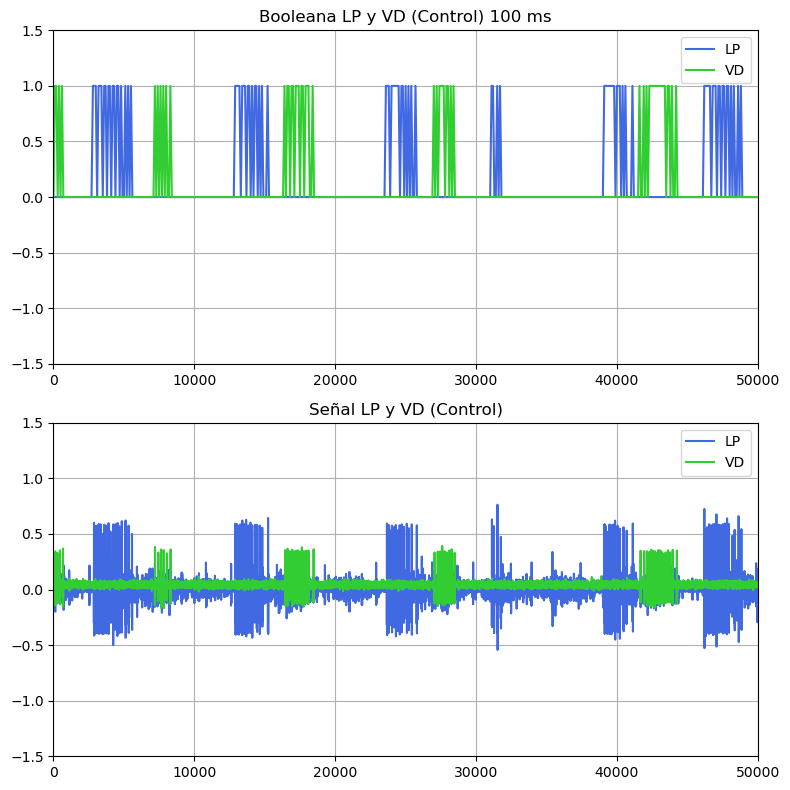

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(señalLPC100[:,0], señalLPC100[:,1], label='LP', color='royalblue')
axs[0].plot(señalVDC100[:,0], señalVDC100[:,1], label='VD', color='limegreen')
axs[0].set_title('Booleana LP y VD (Control) 100 ms')
axs[0].legend(loc="upper right")
axs[0].set_xlim([0, 50000])
axs[0].set_ylim([-1.5, 1.5])
axs[0].grid(True)

axs[1].plot(trozoC['LP'], label='LP', color='royalblue')
axs[1].plot(trozoC['VD'], label='VD', color='limegreen')
axs[1].set_title('Señal LP y VD (Control)')
axs[1].legend(loc="upper right")
axs[1].set_xlim([0, 50000])
axs[1].set_ylim([-1.5, 1.5])
axs[1].grid(True)

plt.tight_layout()
plt.show()



De esta forma hemos transformado la señal de la LP (Control) en una booleana de la presencia de spikes. Pero para saber si estamos perdiendo mucha información vamos a comparar el resultado con la transformación dato a dato que hemos realizado previamente. Para ello compararemos el número de spikes (unos) que se han almacenado en los 10000 primeros segundos para la LP.

70 spikes recogidos en los primeros 10000 ms
23.0 spikes reconstruidos en los primeros 10000 ms con ventana de 10 ms
18.0 spikes reconstruidos en los primeros 10000 ms con ventana de 100 ms


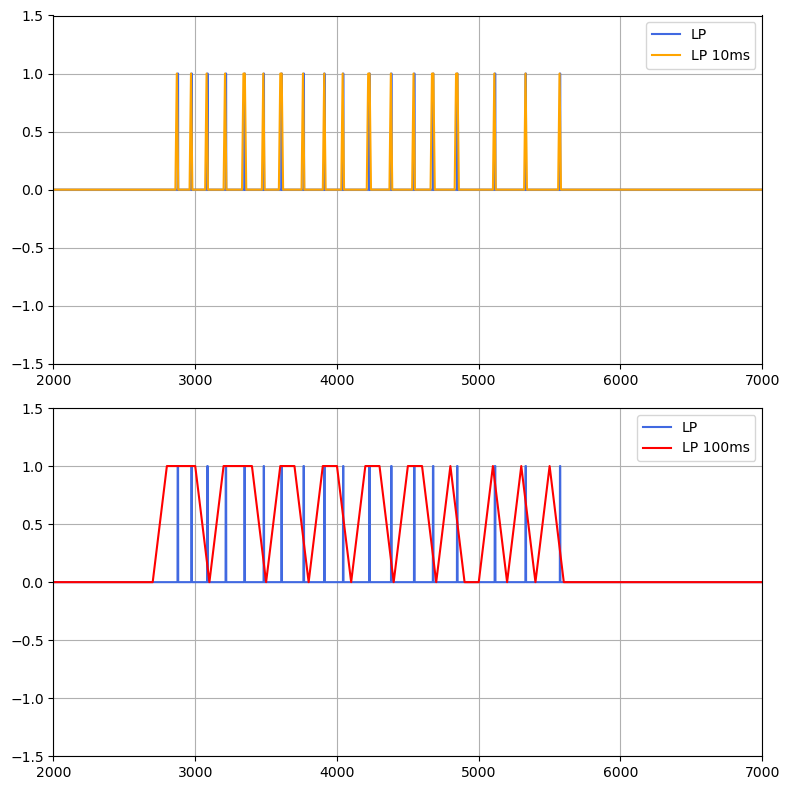

In [15]:
# Comprobar si cada dato correponde a 1ms. Si fuese 0.1ms hay que corregir el índice

print(SLPC.head(10000).sum(),'spikes recogidos en los primeros 10000 ms')
print(señalLPC10[:,1][señalLPC10[:,0]<10000].sum(),'spikes reconstruidos en los primeros 10000 ms con ventana de 10 ms')
print(señalLPC100[:,1][señalLPC100[:,0]<10000].sum(),'spikes reconstruidos en los primeros 10000 ms con ventana de 100 ms')

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(SLPC,label='LP',color='royalblue')
axs[0].plot(señalLPC10[:,0],señalLPC10[:,1],label='LP 10ms',color='orange')
axs[0].legend(loc="upper right")
axs[0].set_xlim([2000, 7000])
axs[0].set_ylim([-1.5, 1.5])
axs[0].grid(True)

axs[1].plot(SLPC,label='LP',color='royalblue')
axs[1].plot(señalLPC100[:,0],señalLPC100[:,1],label='LP 100ms',color='red')
axs[1].legend(loc="upper right")
axs[1].set_xlim([2000, 7000])
axs[1].set_ylim([-1.5, 1.5])
axs[1].grid(True)

plt.tight_layout()
plt.show()


Vemos como el intervalo de 10 ms reconstruye mucho mejor la señal original de la LP que con el intervalo de 100 ms. Además, lo hace considerando un número considerablemente menor de spikes: 23 spikes, frente a los 70 que se almacenan en la señal original. Aun así, reconstruye el espectro con muy buena precisión. 